http://www.learnnc.org/lp/editions/few/684

*A writer’s style* is what sets his or her writing apart and makes it unique. Style is the way writing is dressed up (or down) to fit the specific context, purpose, or audience. Word choice, sentence fluency, and the writer’s voice — all contribute to the style of a piece of writing.

**Elements of style**

Many elements of writing contribute to an author’s style, but three of the most important are ***word choice***, sentence fluency, and voice.

Good writers are concise and precise, weeding out unnecessary words and choosing the exact word to convey meaning. Precise words — active verbs, concrete nouns, specific adjectives — help the reader visualize the sentence. **Good writers use adjectives sparingly and adverbs rarely, letting their nouns and verbs do the work.**

Good writers also choose words that contribute to the flow of a sentence. Polysyllabic words, alliteration, and consonance can be used to create sentences that roll off the tongue. Onomatopoeia and short, staccato words can be used to break up the rhythm of a sentence. 

My idea is to extract meaningful words - adjectives, nouns and verbs- that describe each writer style. 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # regular expressions
from collections import Counter # for counting
# spacy
import spacy
from spacy.parts_of_speech import ADV,ADJ,VERB
from spacy.symbols import nsubj,ORTH,LEMMA, POS,PERSON
from pathlib import Path


In [7]:
DATA_DIR = Path("/ssd_data/kagle/spooky-author-identification/input")

train = pd.read_csv(str(DATA_DIR / Path("train.csv")), encoding = "utf8")
#train.shape
#train.head()

For understanding spacy I'll focus on the first author EAP:

In [8]:
list_EAP = list(train.text[train.author == "EAP"])
list_EAP[0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [9]:
len(list_EAP)

7900

In [10]:
def list_to_text(l):
    document = " "
    for s in range(len(l)):
        sent = "".join(l[s]).strip()
        document += sent
    return document

In [11]:
text_EAP = list_to_text(list_EAP)
#text_EAP
#len(text_EAP)

In [14]:
#import en_core_web_sm
#nlp = en_core_web_sm.load()

nlp = spacy.load('en')

https://spacy.io/usage/processing-pipelines 

When you call nlp on a text, spaCy first tokenizes the text to produce a Doc object. The Doc is then processed in several different steps – this is also referred to as the processing pipeline. The pipeline used by the default models consists of a tagger, a parser and an entity recognizer. Each pipeline component returns the processed Doc, which is then passed on to the next component.

In [15]:
eap = nlp(text_EAP)

In [16]:
#dir(eap)
#eap.is_parsed
eap.is_tagged
#eap.doc

True

In [17]:
#Just to know how many sentences.
#It's not importnat to focus on sentnces but words.
sentences = [sentence.orth_ for sentence in eap.sents]
print("There are {} sentences.".format(len(sentences)))

There are 7423 sentences.


**Noun phrases:**
* **Text**: The original noun chunk text.
* **Root text**: The original text of the word connecting the noun chunk to the rest of the parse.
* **Root dep**: Dependcy relation connecting the root to its head.
* **Root head text**: The text of the root token's head.

In [18]:
chunks = [(chunk.text, chunk.root.text, chunk.root.dep_,chunk.root.head.text) for chunk in eap.noun_chunks]
df = pd.DataFrame(chunks)
df.head()

,0,1,2,3
0,This process,process,nsubj,afforded
1,me,me,dobj,afforded
2,no means,means,dobj,afforded
3,the dimensions,dimensions,dobj,ascertaining
4,my dungeon,dungeon,pobj,of


In [19]:
tokens = [(token.text, token.dep_, token.head.text, token.head.pos_, [child for child in token.children]) for token in eap]
df = pd.DataFrame(tokens)
df.head()

,0,1,2,3,4
0,,,This,DET,[]
1,This,det,process,NOUN,[ ]
2,process,nsubj,afforded,VERB,[This]
3,",",punct,afforded,VERB,[]
4,however,advmod,afforded,VERB,[]


**Tokens:**
* **Text**: The original token text.
* **Dep**: The syntactic relation connecting child to head.
* **Head text**: The original text of the token head.
* **Head POS**: The part-of-speech tag of the token head.
* **Children**: The immediate syntactic dependents of the token.

In [20]:
#AN example to check if "'s" and "'nt" are tokens with the spacy default tokenizer
doc = nlp("some cleaning does'nt hurt. so let's do it")#some times mistake like this does'nt occur ==> more work to check spelling
doc1 = nlp("some cleaning doesn't hurt. so let's do it")# correct this our example
tokens = [token.orth_ for token in doc]
tokens1 = [token.orth_ for token in doc1]
print(tokens,"\n",tokens1)

['some', 'cleaning', "does'nt", 'hurt', '.', 'so', 'let', "'s", 'do', 'it'] 
 ['some', 'cleaning', 'does', "n't", 'hurt', '.', 'so', 'let', "'s", 'do', 'it']


With spacy the default tokenizer is good. But may be we'll need to customize it. We will see in further steps.

**Some counting:**

In [21]:
tokens = [token.orth_ for token in eap]
print("There are {} tokens".format(len(tokens)))

There are 228100 tokens


In [22]:
Counter(tokens).most_common(10)

[(',', 17594),
 ('the', 13957),
 ('of', 8938),
 ('.', 6486),
 ('and', 5477),
 ('to', 4647),
 ('a', 4531),
 ('in', 3773),
 ('I', 3605),
 ('that', 2260)]

In [23]:
#let's clean our eap doc
cleaned_tokens = [token.orth_ for token in eap if not token.is_punct | token.is_space]
print("There are {} cleaned tokens".format(len(cleaned_tokens)))

There are 199871 cleaned tokens


In [24]:
Counter(cleaned_tokens).most_common(10)

[('the', 13957),
 ('of', 8938),
 ('and', 5477),
 ('to', 4647),
 ('a', 4531),
 ('in', 3773),
 ('I', 3605),
 ('that', 2260),
 ('was', 2201),
 ('it', 1829)]

(',', 17594) and ('.', 6486) are ignored after cleaning.

Lemmatization:
Lemmatisation is the process of reducing a word to its base form. Different uses of a word often have the same root meaning. For example, program, programmed and programming all essentially refer to the same thing. 
Lemmatization avoids word duplication and, therefore, allows for the model to build a clearer picture of patterns of word usage across multiple documents.



In [25]:
lemmas = [(i,i.lemma_) for i in eap]
print("There are {} lemmas".format(len(lemmas)))

There are 228100 lemmas


In [26]:
Counter(lemmas).most_common(10)

[(( , ' '), 1),
 ((This, 'this'), 1),
 ((process, 'process'), 1),
 ((,, ','), 1),
 ((however, 'however'), 1),
 ((,, ','), 1),
 ((afforded, 'afford'), 1),
 ((me, '-PRON-'), 1),
 ((no, 'no'), 1),
 ((means, 'mean'), 1)]

POS Tagging
Part-of-speech tagging is the process of assigning grammatical properties (e.g. noun, verb, adverb, adjective etc.) to words. Words that share the same POS tag tend to follow a similar syntactic structure and are useful in rule-based processes.

In [27]:
pos_tags = [(i, i.tag_) for i in eap]
print("There are {} pos_tags".format(len(pos_tags)))

There are 228100 pos_tags


In [28]:
Counter(pos_tags).most_common(10)

[(( , ''), 1),
 ((This, 'DT'), 1),
 ((process, 'NN'), 1),
 ((,, ','), 1),
 ((however, 'RB'), 1),
 ((,, ','), 1),
 ((afforded, 'VBD'), 1),
 ((me, 'PRP'), 1),
 ((no, 'DT'), 1),
 ((means, 'NNS'), 1)]

Here I'm trying to extract some part of speech which can be useful for further steps.

In [29]:
def is_verb(token):
    return token.pos == spacy.parts_of_speech.VERB

In [30]:
verbs = set()
for t in eap:
    if is_verb(t):
        verbs.add(t.head)
len(verbs),Counter(verbs).most_common(10)

(22150,
 [(able, 1),
  (withdraw, 1),
  (intending, 1),
  (took, 1),
  (is, 1),
  (regard, 1),
  (possessed, 1),
  (went, 1),
  (entered, 1),
  (sent, 1)])

Something wrong?
(everything, 1)??? may you get different mistake.

**Tip:** Good idea to extract right words, is to combine rules.

In [31]:
verbs = set()
for subject in eap:
    if subject.dep == nsubj and subject.head.pos == VERB:
        verbs.add(subject.head)
len(verbs),Counter(verbs).most_common(10)

(14264,
 [(stands, 1),
  (am, 1),
  (eats, 1),
  (experienced, 1),
  (is, 1),
  (whispered, 1),
  (were, 1),
  (stated, 1),
  (telling, 1),
  (withdraw, 1)])

In [32]:
def is_adverb(token):
    return token.pos == spacy.parts_of_speech.ADV
adverbs = set()
for t in eap:
    if is_adverb(t):
        adverbs.add(t.head)
len(adverbs),Counter(adverbs).most_common(10)

(13428,
 [(mines, 1),
  (is, 1),
  (is, 1),
  (were, 1),
  (is, 1),
  (cordial, 1),
  (pointed, 1),
  (stated, 1),
  (telling, 1),
  (afflicted, 1)])

In [33]:
def is_adjective(token):
    return token.pos == spacy.parts_of_speech.ADJ
adjectives = set()
for t in eap:
    if is_adjective(t):
        adjectives.add(t.head)
len(adjectives),Counter(adjectives).most_common(10)

(20737,
 [(parents, 1),
  (awe, 1),
  (ability, 1),
  (head, 1),
  (fulness, 1),
  (ugh, 1),
  (stands, 1),
  (waters, 1),
  (thinking, 1),
  (am, 1)])

Entity recognition
Entity recognition is the process of classifying named entities found in a text into pre-defined categories, such as persons, places, organizations, dates, etc.

In [34]:
entities = [(i,i.label_) for i in eap.ents] 
len(entities),Counter(entities).most_common(10)

(6097,
 [((Epicurus, 'ORG'), 1),
  ((Greek, 'NORP'), 1),
  ((Orion, 'PRODUCT'), 1),
  ((one, 'CARDINAL'), 1),
  ((Draconian, 'NORP'), 1),
  ((academy?These, 'NORP'), 1),
  ((Pure, 'ORG'), 1),
  ((California, 'GPE'), 1),
  ((Von Kempelen's, 'PERSON'), 1),
  ((Arnheim, 'GPE'), 1)])

In [35]:
#count just labels
labels = [i.label_ for i in eap.ents] 
len(labels),Counter(labels).most_common(10)

(6097,
 [('PERSON', 1374),
  ('CARDINAL', 916),
  ('ORG', 854),
  ('GPE', 588),
  ('DATE', 519),
  ('TIME', 449),
  ('ORDINAL', 397),
  ('NORP', 288),
  ('LOC', 214),
  ('QUANTITY', 187)])

In [36]:
#If you want to know a label meaning
spacy.explain('GPE')

'Countries, cities, states'

To learn more and master spacy's linguistic features see : https://spacy.io/usage/linguistic-features

**SERIOUS WORK:**

1. Cleaning each document,(N.B: some sentences are for French language.)
1. Extract significant words related to the author style (adjectives, verbs, adverbs)
1. word embedding
1. RNN model for training



**STEP 1: CLEANING**

During my experience with this text I've noticed:
1. some mistake such as ("Bransby's?Wrap",),('ensue.i', 1) 
1. some similar names 'Elah Gabalah',  'Elah Gabalus' (I don' know if it's a mistake or they are different person).
1. ("dxn't dx", 1),  ('massa de lef eye jis', 1),?????? not entities

In [37]:
# Useful functions:
# transform lists to texts
def list_to_text(l):
    text = " "
    for s in range(len(l)):
        sent = "".join(l[s]).strip()
        text += sent
    return text
# Clean up the texts
def cleanText(text):
    text = text.strip().replace("?","? ").replace(".",". ")
    text = text.lower()
    return text
# Get the documents with spacy
def to_nlp(text):
    nlp = spacy.load('en')
    cleaned_text = cleanText(text)
    document = nlp(cleaned_text)
    return document

**First author EAP:**

In [38]:
list_EAP = list(train.text[train.author == "EAP"])

In [39]:
text_eap = list_to_text(list_EAP)

In [40]:
eap = to_nlp(text_eap)

In [41]:
len(eap)

233451

**Second author HPL:**

In [42]:
list_HPL = list(train.text[train.author == "HPL"])

In [43]:
text_hpl = list_to_text(list_HPL)

In [44]:
hpl = to_nlp(text_hpl)

In [45]:
len(hpl)

174453

**Third author MWS:**

In [46]:
list_MWS = list(train.text[train.author == "MWS"])

In [47]:
text_mws = list_to_text(list_MWS)

In [48]:
mws = to_nlp(text_mws)

In [49]:
len(mws)

188973

**STEP2: EXTRACTING WORDS**

In [50]:
from collections import defaultdict
def dict_words(list_words,limit):
    counter = defaultdict(int)
    for k in list_words:
        counter[k] += 1
    dict_words = sorted(counter.items(),key=lambda x: x[1])
    highly_used_words=list()
    for i in range(len(dict_words)):
        if dict_words[i][1]>=limit:
            highly_used_words.append([dict_words[i][0]])
    return highly_used_words

In [51]:
verbs = list()
for subject in eap:
    if subject.dep == nsubj and subject.head.pos == VERB:
        verbs.append(subject.head.lemma_)

In [52]:
#highly_used_verbs
highly_used_verbs = dict_words(verbs,100)

In [53]:
#just testing here....
eap_heros = list()
for ent in eap.ents:
    if ent.label_ in ['PERSON','NORP','GPE']:
        eap_heros.append(ent)
len(eap_heros),Counter(eap_heros).most_common(10)

(175,
 [(california, 1),
  (christian, 1),
  ( , 1),
  ( , 1),
  ( , 1),
  ( , 1),
  ( , 1),
  (g., 1),
  ( , 1),
  ( , 1)])

In [54]:
highly_used_heros = dict_words(eap_heros,1)
#highly_used_heros

["],[j],[ ],[dxn't dx], [however], [massa de lef eye jis] are mistakes.

In [55]:
# For each author I'll select unique vocabulary
#eap_vocabulary = highly_used_verbs + highly_used_heros + ....

**STEP3: WORD EMBEDDING**

https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

**What are Word Embeddings?**

In very simplistic terms, Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. But before we dive into the details of Word Embeddings, the following question should be asked – Why do we need Word Embeddings?

**Different types of Word Embeddings:**

The different types of word embeddings can be broadly classified into two categories:
*     Frequency based Embedding
*     Prediction based Embedding

In [56]:
from gensim.models import Word2Vec

Using TensorFlow backend.


https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

* **size**: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
* **window**: (default 5) The maximum distance between a target word and words around the target word.
* **min_count**: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* **workers**: (default 3) The number of threads to use while training.
* **sg**: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [57]:
# train model
model = Word2Vec(highly_used_verbs, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=19, size=100, alpha=0.025)
['lie', 'give', 'appear', 'speak', 'become', 'feel', 'go', 'do', 'think', 'come', 'find', 'take', 'seem', 'know', 'make', 'see', 'say', 'have', 'be']


In [58]:
vocabulary_size = len(model.wv.vocab) #vocab=19
vocabulary_size

19

In [59]:
# access vector for one word size = 100
print(model['be'])

[ -1.61240331e-03  -4.61693760e-03   4.04398888e-03   2.90224416e-04
   6.28177368e-04   1.82415009e-03   2.75202515e-03  -4.29000426e-03
  -1.25402259e-03  -4.28610248e-03   4.09889640e-03  -1.72772969e-03
  -4.12441231e-03  -4.49806685e-03   4.68318025e-03  -9.34383424e-04
   3.69544770e-03  -3.03134415e-03   1.17809082e-04  -1.32469926e-03
  -4.75927349e-03  -3.30509548e-03  -4.60619433e-03  -1.67225651e-03
  -5.75813290e-04   3.97823937e-03   1.88497861e-03  -1.17223349e-03
   5.57196152e-04   1.53996691e-04  -4.07228060e-03  -4.70788422e-04
  -2.38969410e-03   5.39254688e-04   2.40281806e-03  -4.07919870e-04
  -4.20269230e-03  -4.31441283e-03  -1.46989347e-04  -6.69802830e-04
  -1.25356636e-03   1.30437512e-03   2.52550095e-03   4.39968938e-03
  -6.00591709e-04  -7.16922514e-05  -3.46194394e-03  -4.38101403e-03
   1.59538782e-03   3.82322073e-03   3.23126907e-03  -3.63556552e-03
  -1.22461788e-04  -4.91338375e-04   1.75380660e-03  -3.92309669e-03
  -2.75006401e-03   1.94479467e-03

In [62]:
model.wv.index2word[10]

'find'

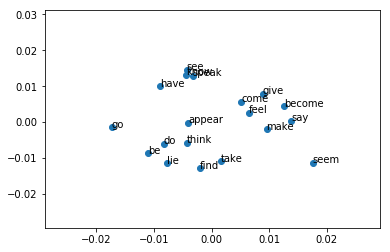

In [61]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

**STEP4: RNN**

* http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/
* https://www.tensorflow.org/tutorials/word2vec
* https://spacy.io/usage/training#section-tips
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://github.com/crazydonkey200/tensorflow-char-rnn

In [ ]:
# For insertion into TensorFlow let's convert the wv word vectors into a numpy matrix
vocabulary_size = len(model.wv.vocab)
vector_dim = 100 #model size
embedding_matrix = np.zeros((vocabulary_size, vector_dim))
for i in range(vocabulary_size):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#embedding_matrix[0][0]

To refresh memory or to be familiar with tensorflow see : http://adventuresinmachinelearning.com/python-tensorflow-tutorial/ 

In [ ]:
import tensorflow as tf 
#Using gensim Word2Vec embeddings in TensorFlow
# embedding layer weights are frozen to avoid updating embeddings while training
frozen_embeddings = tf.constant(embedding_matrix)
embedding = tf.Variable(initial_value=frozen_embeddings, trainable=False)
# trainable=False, otherwise the embedding layer would be trained with negative performance impacts. 

**STARTING RNN MODEL**:
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/
* http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/